In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np 
from tensorflow import keras 
from keras.layers import *
from keras.models import Model

In [39]:
from keras.initializers import glorot_uniform
def identity_block(X,f,filters,stage,block):
    """ 
    this function will create a res block with 3 layer 
    
    arguments:
    X -- input of block is kind of keras layer  
    f -- fiter size of middle convolution layer with shape of (m,h,w,c)
    filters -- list of integer .represent number of filter in eath layer 
    stage -- integer used to name the layer 
    block -- string/characher used for naming layer 
    
    returns:
    a2 -- output of identity block with shape of (m,h,w,c_n)
    
    """
    #create variable for naming layer 
    conv_name_base = 'res'+str(stage)+block+"_branch"
    bn_name_base = "bn" + str(stage)+block+"_branch"
    # retrive filters 
    f1 , f2,f3 = filters 

    # first sub layer  
    conv1 = Conv2D(f1,1,name=conv_name_base+"2a")(X)
    bn1 = BatchNormalization(axis=3,name = bn_name_base+"2a")(conv1)
    a1 = Activation("relu")(bn1)

    # second sub layer
    conv2 = Conv2D(f2,f,padding="same",name=conv_name_base+"2b")(a1)
    bn2 = BatchNormalization(axis=3,name = bn_name_base+"2b")(conv2)
    a2 = Activation("relu")(bn2)

    # third sub layer
    conv3 = Conv2D(f3,1,name=conv_name_base+"2c")(a2)
    bn3 = BatchNormalization(axis=3,name = bn_name_base+"2c")(conv3)

    # adding shortcut to main path 
    add = Add()([bn3,X])

    # last activation 
    a2 = Activation("relu")(add)

    return a2



In [42]:
np.random.seed(0)
X = np.random.randn(1,3, 4, 4, 6)
A_prev = Input(dtype="float",shape= [3, 4, 4, 6])
A  = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
model = keras.Model(inputs=A_prev,outputs=A)
out = model.predict(X)
print("out = " + str(out[0][1][1][0]))

1/1 [==============================] - 0s 391ms/step
out = [0.45097503 0.         0.44953114 1.2982757  0.         0.        ]


In [43]:
def convolutional_block(X,f,filters,stage,block,s=2):
    """ 
    this function will create a res block with 3 layer 
    
    arguments:
    X -- input of block is kind of keras layer  
    f -- fiter size of middle convolution layer with shape of (m,h,w,c)
    filters -- list of integer .represent number of filter in eath layer 
    stage -- integer used to name the layer 
    block -- string/characher used for naming layer 
    s -- stride for shortcut layre conv
    
    returns:
    a2 -- output of identity block with shape of (m,h_n,w_n,c_n)
    
    """
    #create variable for naming layer 
    conv_name_base = 'res'+str(stage)+block+"_branch"
    bn_name_base = "bn" + str(stage)+block+"_branch"
    # retrive filters 
    f1 , f2,f3 = filters 

    # first sub layer  
    conv1 = Conv2D(f1,1,name=conv_name_base+"2a")(X)
    bn1 = BatchNormalization(axis=3,name = bn_name_base+"2a")(conv1)
    a1 = Activation("relu")(bn1)

    # second sub layer
    conv2 = Conv2D(f2,f,padding="same",name=conv_name_base+"2b")(a1)
    bn2 = BatchNormalization(axis=3,name = bn_name_base+"2b")(conv2)
    a2 = Activation("relu")(bn2)

    # third sub layer
    conv3 = Conv2D(f3,1,name=conv_name_base+"2c")(a2)
    bn3 = BatchNormalization(axis=3,name = bn_name_base+"2c")(conv3)

    # layer of shortcut
    conv_ = Conv2D(f3,1,stride=s,name=conv_name_base+"1")(X)
    bn_ = BatchNormalization(axis=3,name = bn_name_base+"1")(conv_)
    # adding shortcut to main path 
    add = Add()([bn3,bn_])

    # last activation 
    a3 = Activation("relu")(add)

    return a3



In [46]:
np.random.seed(0)
X = np.random.randn(1,3, 4, 4, 6)
A_prev = Input(dtype="float",shape= [3, 4, 4, 6])
A  = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
model = keras.Model(inputs=A_prev,outputs=A)
out = model.predict(X)
print("out = " + str(out[0][1][1][0]))

1/1 [==============================] - 0s 437ms/step
out = [0.37642553 0.         0.2982382  1.3263859  0.         0.        ]


In [48]:
def ResNet50(input_shape=(64,64,3),classes=6):
    """ 
    implement resnet with 50 layers 

    arguments:
    input_shape -- shape of input images of network 
    classes -- integer , number of classes 

    return:
    model -- resnet model 
    """

    x_input = Input(input_shape)

    x = ZeroPadding2D((3,3))(x_input)

    # stage 1 
    x = Conv2D(64,7,strides=2,name="conv1")(x)
    x = BatchNormalization(axis=3,name="bn1")(x)
    x = Activation("relu")(x)
    x = MaxPool2D((3,3),strides=(2,2))(x)

    #stage 2
    x = convolutional_block(x,3,[64,64,256],2,"a",s=1)
    x = identity_block(x,3,[64,64,256],2,"b")
    x = identity_block(x,3,[64,64,256],2,"c")

    # stage 3
    x = convolutional_block(x,3, [128,128,512],3,"a",s=2)
    x = identity_block(x,3, [128,128,512],3,"b")
    x = identity_block(x,3, [128,128,512],3,"c")
    x = identity_block(x,3, [128,128,512],3,"d")

    # stage 4 
    x = convolutional_block(x,3, [256, 256, 1024],4,"a",s=2)
    x = identity_block(x,3, [256, 256, 1024],4,"b")
    x = identity_block(x,3, [256, 256, 1024],4,"c")
    x = identity_block(x,3, [256, 256, 1024],4,"d")
    x = identity_block(x,3, [256, 256, 1024],4,"e")
    x = identity_block(x,3, [256, 256, 1024],4,"f")

    # stage 5 [512, 512, 2048]
    x = convolutional_block(x,3,[512, 512, 2048],5,"a",s=2)
    x = identity_block(x,3,[512, 512, 2048],5,"b")
    x = identity_block(x,3,[512, 512, 2048],5,"c")


    x = AveragePooling2D((2,2),name="avg_pool")(x)
    x = Flatten()(x)
    x = Dense(classes,name="fc"+str(classes))(x)
    
    model = keras.Model(inputs=x_input , outputs=x)


    return model
    

In [49]:
model = ResNet50()

In [51]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

In [54]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_16[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn1 (BatchNormalization)    (None, 32, 32, 64)           256       ['conv1[0][0]']        

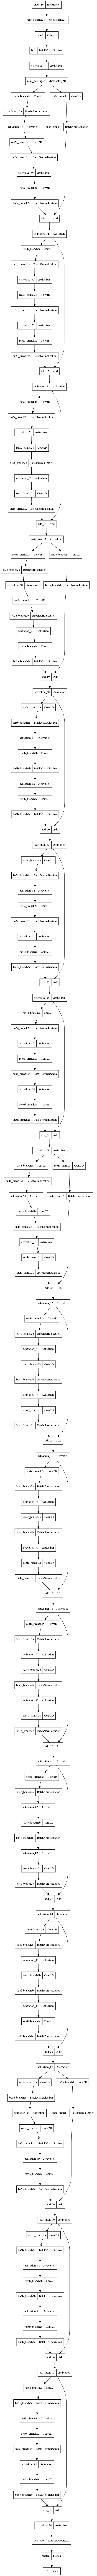

In [55]:
keras.utils.plot_model(model)

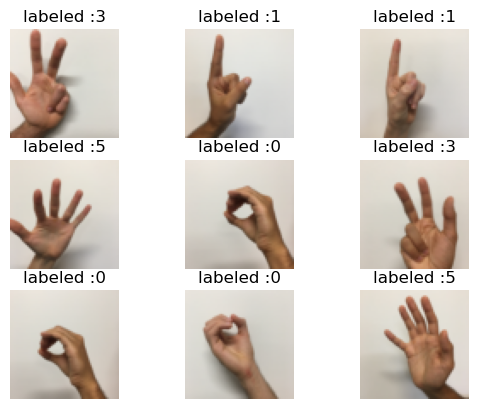

In [59]:
import h5py
train_set = h5py.File("datasets/train_signs.h5","r")
test_set = h5py.File("datasets/test_signs.h5","r")

#<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>
x_train = np.array(train_set["train_set_x"])
x_test = np.array(test_set["test_set_x"])
y_train = np.array(train_set["train_set_y"])
y_test = np.array(test_set["test_set_y"])
classes = np.array(train_set["list_classes"])

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[46+i])
    plt.title("labeled :"+str(y_train[46+i]))
    plt.axis("off")

In [62]:
x_train = x_train/255.
x_test = x_test/255.

In [63]:
x_train.shape , y_train.shape , x_test.shape , y_test.shape

((1080, 64, 64, 3), (1080,), (120, 64, 64, 3), (120,))

In [66]:
model.fit(x_train,y_train,batch_size=32,epochs=20,validation_data=(x_test,y_test))

Epoch 1/20
34/34 [==============================] - 39s 1s/step - loss: 0.2412 - accuracy: 0.9213 - val_loss: 7.7847 - val_accuracy: 0.1667
Epoch 2/20
34/34 [==============================] - 40s 1s/step - loss: 0.2190 - accuracy: 0.9361 - val_loss: 11.0838 - val_accuracy: 0.1667
Epoch 3/20
34/34 [==============================] - 43s 1s/step - loss: 0.2325 - accuracy: 0.9287 - val_loss: 8.3457 - val_accuracy: 0.2000
Epoch 4/20
34/34 [==============================] - 38s 1s/step - loss: 0.2101 - accuracy: 0.9407 - val_loss: 7.6597 - val_accuracy: 0.1833
Epoch 5/20
34/34 [==============================] - 37s 1s/step - loss: 0.2182 - accuracy: 0.9389 - val_loss: 4.7593 - val_accuracy: 0.1750
Epoch 6/20
34/34 [==============================] - 36s 1s/step - loss: 0.1514 - accuracy: 0.9556 - val_loss: 6.8598 - val_accuracy: 0.2333
Epoch 7/20
34/34 [==============================] - 36s 1s/step - loss: 0.1136 - accuracy: 0.9713 - val_loss: 12.8781 - val_accuracy: 0.2833
Epoch 8/20
34/34 [

it is very heavy and its traiing is too long 

In [67]:
model.save("resnet50_myself.keras")

In [91]:
#"images/smile.jpg"
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
def img_p(path):
    img = image.load_img(path,target_size=(64,64,3))
    plt.imshow(img)
    x = image.img_to_array(img)
    x = x /255. 
    #x = preprocess_input(x)
    return np.expand_dims(x,axis=0) 
    

1/1 [==============================] - 0s 125ms/step
[[-2.380664   -4.788916    1.5493242   3.130253    3.6452386  -0.01827562]]
tf.Tensor(
[[1.3812046e-03 1.2427034e-04 7.0312127e-02 3.4167948e-01 5.7183969e-01
  1.4663252e-02]], shape=(1, 6), dtype=float32)


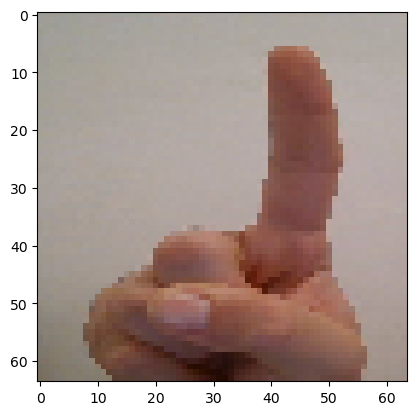

In [92]:
x = img_p("images/1.jpg")
print(model.predict(x),Softmax()(model.predict(x)),sep="\n")

1/1 [==============================] - 0s 129ms/step
[[-2.8344123  -3.4119875   3.6341662  -0.9318691   4.5554566  -0.34195784]]
tf.Tensor(
[[4.3774873e-04 2.4568971e-04 2.8215829e-01 2.9341942e-03 7.0893127e-01
  5.2927816e-03]], shape=(1, 6), dtype=float32)


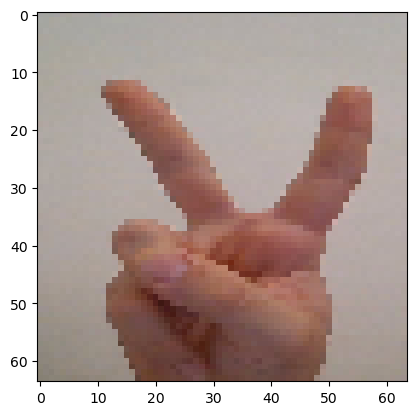

In [93]:
y = img_p("images/2.jpg")
print(model.predict(y),Softmax()(model.predict(y)),sep="\n")

1/1 [==============================] - 0s 138ms/step
[[-2.1519678  -2.8995728  -0.92502034 -3.0589309  -0.05179714  9.039731  ]]
tf.Tensor(
[[1.3785619e-05 6.5274776e-06 4.7020036e-05 5.5659279e-06 1.1259497e-04
  9.9981445e-01]], shape=(1, 6), dtype=float32)


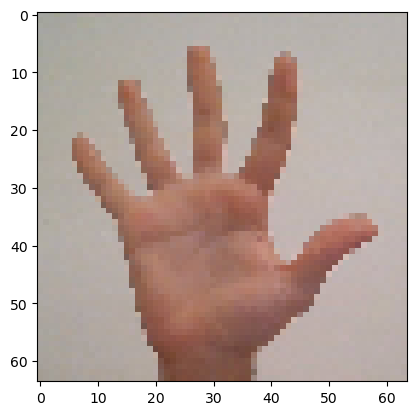

In [94]:
z = img_p("images/5.jpg")
print(model.predict(z),Softmax()(model.predict(z)),sep="\n")

1/1 [==============================] - 0s 132ms/step
[[-2.483662  -1.8083967 -1.7207862 -1.066297   0.2744454  6.8281403]]
tf.Tensor(
[[9.0147936e-05 1.7710049e-04 1.9331624e-04 3.7197125e-04 1.4216297e-03
  9.9774581e-01]], shape=(1, 6), dtype=float32)


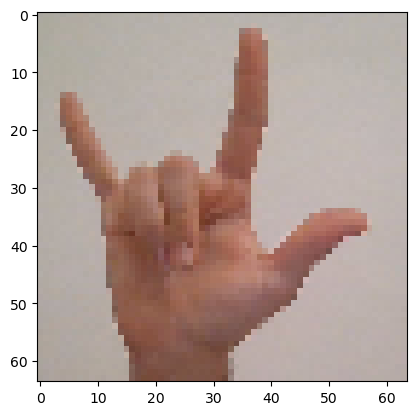

In [95]:
k = img_p("images/3_m.jpg")
print(model.predict(k),Softmax()(model.predict(k)),sep="\n")

1/1 [==============================] - 0s 101ms/step
[[-0.86293906 -3.7334757  -3.0490959  -1.671429    1.3571111   8.215128  ]]
tf.Tensor(
[[1.1400123e-04 6.4602782e-06 1.2807769e-05 5.0791015e-05 1.0496994e-03
  9.9876630e-01]], shape=(1, 6), dtype=float32)


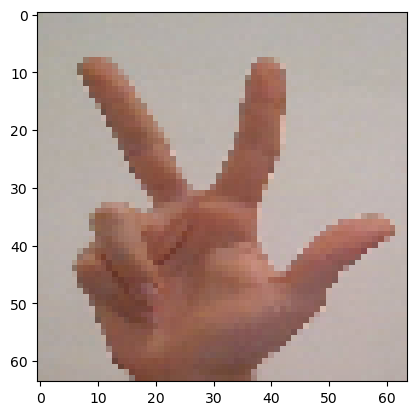

In [96]:
h = img_p("images/3_g.jpg")
print(model.predict(h),Softmax()(model.predict(h)),sep="\n")

1/1 [==============================] - 0s 93ms/step
[[-3.719057   -1.182209   -0.5968201   4.824576    1.7205613   0.25968072]]
tf.Tensor(
[[1.8334830e-04 2.3174791e-03 4.1614706e-03 9.4130278e-01 4.2235043e-02
  9.7998772e-03]], shape=(1, 6), dtype=float32)


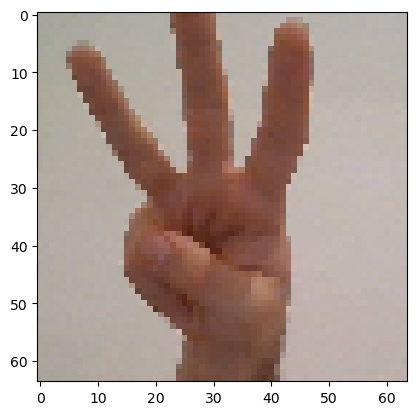

In [97]:
j = img_p("images/3_c.jpg")
print(model.predict(j),Softmax()(model.predict(j)),sep="\n")

i think beacuse of my image come from diffrent distribution t, model cant act accuratly 